<h1>Logistic Regression</h1>
<h1>______________________________________</h1>

<p>Logistic Regression is a variation of Linear Regression, used for categorical outputs. It is actually a <b>probabilistic classification</b> model.</p>
<p><i><b>
$$
ProbabilityOfaClass = \theta(y) = \frac{e^y}{1 + e^y} = exp(y) / (1 + exp(y)) = p 
$$
</b></i></p>


<h2>Logistic Regression with Tensorflow</h2>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

<p>We will load the <b>iris</b> dataset which is inbuilt in sklearn, so we don't have to preprocess it.We separate dataset into xs and ys, and then into training xs and ys.</p>
<p>You can read about the data <a href= 'https://archive.ics.uci.edu/ml/datasets/iris'>here</a></p>

In [5]:
iris = load_iris()
iris_X, iris_y = iris.data[:-1,:], iris.target[:-1]
iris_y= pd.get_dummies(iris_y).values
trainX, testX, trainY, testY = train_test_split(iris_X, iris_y, test_size=0.33, random_state=42)

<p>We define x and y, these placeholders will hold our iris data (both features and label matrices), and help pass them along to different parts of the algorithm. We need to give them shapes which correspond to the shape of our data. Later, we will insert data into these placeholders by "feeding" the placeholders the data via a "feed_dict"(Feed Dictionary)</p>

In [7]:
numFeatures = trainX.shape[1]
numLabels = trainY.shape[1]

#placeholders
X = tf.placeholder(tf.float32, [None, numFeatures]) # Iris has 4 features, so X is a tensor to hold our data
yGold = tf.placeholder(tf.float32, [None, numLabels]) # This is our original output for 3 classesb

<h3>Model weights and bias</h3>

In [14]:
W = tf.Variable(tf.zeros([4,3])) # 4D input and 3 classes
b = tf.Variable(tf.zeros([3])) # 3D output [0,0,1],[0,1,0],[1,0,0]

In [17]:
# Randomly sample from a normal distribution with standard deviation 0.01
weights = tf.Variable(tf.random_normal([numFeatures, numLabels], mean = 0, stddev=0.01, name="weights"))
bias = tf.Variable(tf.random_normal([1, numLabels], mean = 0, stddev = 0.01, name="bias"))

<h3>Logistic Regression model</h3>
<p>Equation: </p>
<p>
    $$
ŷ =sigmoid(WX+b)
$$

<p>
    
Its three main components: 
- a weight times features matrix multiplication operation, 
- a summation of the weighted features and a bias term, 
- and finally the application of a sigmoid function. 


In [19]:
apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias,name="add_bias")
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

<h3>Training</h3>

<h4>Cost function</h4>
Before defining our cost function we need to define our learning rate and number of epochs

In [22]:
numEpochs = 1000
learningRate = tf.train.exponential_decay(learning_rate = 0.0008, global_step=1, decay_steps=trainX.shape[0], 
                                          decay_rate=0.95, staircase=True)

In [23]:
# Cost function: Square mean error
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

# Gradient Descent
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

Initialize all variable and start the session

In [24]:
# Create a session
sess = tf.Session()
# initialize our weights and biases
init_OP = tf.global_variables_initializer()
# Initialize all tf variables
sess.run(init_OP)

Stuffs to keep track of our models efficiency over time

In [32]:
# argmax(activation_OP, 1) returns the label with the most probability
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))

# 0 for false and 1 for true means the avg is accuracy
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))

# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)

# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)

# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)

# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))

# Merge all summaries
merged = tf.summary.merge([activation_summary_OP, accuracy_summary_OP, cost_summary_OP, weightSummary, biasSummary])

# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

Define and run the actual training loop

In [34]:
# initialize reporting variables
cost = 0
diff = 1
epoch_values = []
accuracy_values = []
cost_values = []

# Training
for i in range(numEpochs):
    if i>1 and diff < 0.0001:
        print("Change in cost %g; convergence. " %diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={X:trainX, yGold: trainY})
        # report occasional stats
        if i%10==0:
            # add epoch to epoch_values
            epoch_values.append(i)
            # generate accuracy stats on test data
            train_accuracy, newCost = sess.run([accuracy_OP, cost_OP], feed_dict={X:trainX, yGold:trainY})
            # add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # add cost to live graphing bariable
            cost_values.append(newCost)
            #Re-assign values for variables
            diff = abs(newCost-cost)
            cost = newCost
            
            print("Step %d, training accuracy %g, cost %g, change in cost %g"%(i,train_accuracy, newCost, diff))
print('Final accuracy on test data: %s' %str(sess.run(accuracy_OP,feed_dict={X:testX, yGold:testY})))
            

Step 0, training accuracy 0.353535, cost 34.9963, change in cost 34.9963
Step 10, training accuracy 0.585859, cost 30.2296, change in cost 4.76676
Step 20, training accuracy 0.646465, cost 28.2664, change in cost 1.96315
Step 30, training accuracy 0.646465, cost 26.6125, change in cost 1.65395
Step 40, training accuracy 0.646465, cost 25.2391, change in cost 1.37335
Step 50, training accuracy 0.646465, cost 24.1047, change in cost 1.13446
Step 60, training accuracy 0.646465, cost 23.1655, change in cost 0.939184
Step 70, training accuracy 0.646465, cost 22.3828, change in cost 0.782618
Step 80, training accuracy 0.646465, cost 21.7249, change in cost 0.657932
Step 90, training accuracy 0.646465, cost 21.1663, change in cost 0.558575
Step 100, training accuracy 0.656566, cost 20.6873, change in cost 0.479006
Step 110, training accuracy 0.666667, cost 20.2725, change in cost 0.414839
Step 120, training accuracy 0.666667, cost 19.9098, change in cost 0.362658
Step 130, training accuracy 0

c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\asus\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


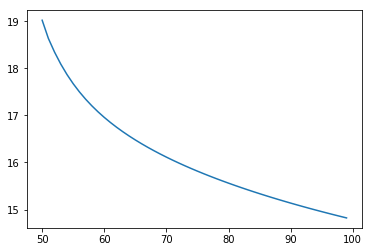

In [35]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.plot([np.mean(cost_values[i-50:i]) for i in range(len(cost_values))])
plt.show()